# 工业场景全流程！保险金额预估机器学习开发并部署服务到云端

本篇内容从头开始构建机器学习管道，使用 Flask 框架构建 Web 应用程序，并部署到云服务器上的过程。具体包括：


- 何为机器学习应用部署
- 基于 PyCaret 开发机器学习全流程
- 基于 Flask 搭建简易前端 Web 应用程序
- 在 Heroku 云上部署机器学习应用

作者：ShowMeAI
链接：https://juejin.cn/post/7144908639965282341
来源：稀土掘金
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

在企业的实际生产中，我们经常会把机器学习模型构建成服务形态，这样协作的开发同事可以通过接口（API）来访问模型服务，完成预估任务，这被称为部署机器学习应用过程。

更全一点说，生产中使用机器学习管道有两种广泛的方式：

- 批量预测

将模型或管道存储在磁盘中，定期运行脚本，加载模型和数据，生成预测并将输出写入磁盘。这种情况下，多个预测会并行。它对于时效性要求不高。

- 在线预测

需要实时预测，大家使用到的很多 app，其实都是输入信息，然后在单击提交按钮时，实时预估生成预测的。比如你在电商平台输入搜索词，点击查询，可以看到模型排序好的结果列表返回。

本教程中，我们讲解的是『在线预测』这种模式。我们将首先使用 PyCaret 在 Python 中构建机器学习管道，然后使用 Flask 构建 Web 应用程序，最后将所有这些部署在 Heroku 云上。

PyCaret的整个机器学习管道（pipeline）如下图所示：

![](https://p3-juejin.byteimg.com/tos-cn-i-k3u1fbpfcp/b5baa5b365114408abbb26bc0226e020~tplv-k3u1fbpfcp-zoom-in-crop-mark:1512:0:0:0.awebp)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

# 第一步：构建机器学习流水线

把整个建模过程构建为一个流水线，这里我们使用 PyCaret，几乎可以自动化地完成这个过程。

## 先查看pycaret.datasets里所有的样例数据

In [2]:
from pycaret.datasets import get_data
all_datasets = get_data('index')

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


## 获取保险费用样例数据

示例的数据来自保险场景，保险公司希望通过使用人口统计学信息和基本患者健康风险特征，更准确地预测患者保单费用，以优化其使用的现金流预测的准确性。数据是 PyCaret 自带的。

In [3]:
insurance_data = get_data('insurance')

# 查看是否有空值，属性是否正确
insurance_data.info()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 对保费数据进行描述分析

In [4]:
insurance_data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [8]:
juice = get_data('juice')

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


## 初始化机器学习设置

In [8]:
from pycaret.regression import *

In [10]:
# s_gpu = setup(insurance_data, target = 'charges', session_id = 123, use_gpu = True, normalize = True)
s = setup(insurance_data, target = 'charges', session_id = 123, normalize = True)

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


上述的代码自动化完成数据转换。
原始数据有7个维度（特征），共1338例数据，转换后生成10个维度，并分为训练集（936例）和测试集（402例）。

~转换后的数据集有 62 个用于训练的特征，这些特征由原始数据集的 7 个特征变换而来。~

机器模型以"charge"（即 保费）为预测目标。

以下为对应的特征列表：

In [22]:
# dir(s)
s.dashboard()

TypeError: RegressionExperiment.dashboard() missing 1 required positional argument: 'estimator'

In [7]:
top3 = compare_models(exclude = ['ransac'], n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2704.9411,23567157.5677,4834.8275,0.8319,0.4448,0.3140,0.0170
rf,Random Forest Regressor,2772.7847,25379240.4648,5024.5579,0.8174,0.4685,0.3304,0.0300
catboost,CatBoost Regressor,2900.1560,25763342.9971,5057.6346,0.8163,0.4816,0.3524,0.2210
lightgbm,Light Gradient Boosting Machine,2989.9577,25391993.0970,5029.6985,0.8157,0.5442,0.3750,0.1680
et,Extra Trees Regressor,2833.3624,28427844.2412,5305.6516,0.7991,0.4877,0.3363,0.0250
ada,AdaBoost Regressor,4198.3012,28689735.5532,5348.5728,0.7955,0.6291,0.7156,0.0100
knn,K Neighbors Regressor,3558.0286,33757213.4000,5798.2844,0.7605,0.4940,0.3628,0.0120
lr,Linear Regression,4296.1416,38317147.9860,6171.0237,0.7312,0.5982,0.4413,0.4310
lar,Least Angle Regression,4303.5559,38388058.4578,6176.5920,0.7306,0.5949,0.4433,0.0090
llar,Lasso Least Angle Regression,4303.4005,38387422.4107,6176.5378,0.7306,0.5941,0.4433,0.0100


In [11]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2651.0179,20312968.8483,4506.9911,0.8787,0.4506,0.3416
1,3045.5971,31786370.9368,5637.9403,0.8152,0.4560,0.2991
2,2526.0336,22219684.6628,4713.7761,0.7187,0.4909,0.3007
3,2996.9384,23247152.1890,4821.5301,0.8059,0.4875,0.3830
4,2847.7050,27163724.2109,5211.8830,0.7980,0.5103,0.3367
5,2580.5742,19052273.4486,4364.8910,0.8774,0.3340,0.2437
6,2366.1844,19241130.1231,4386.4713,0.8691,0.3504,0.2649
7,2673.5009,25507898.8469,5050.5345,0.8597,0.4415,0.2750
8,2322.3901,18562845.6362,4308.4621,0.8801,0.3889,0.2887


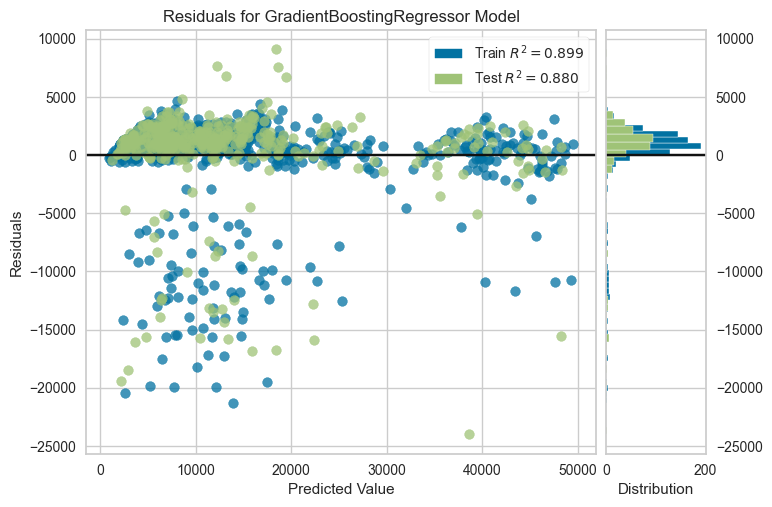

In [12]:
plot_model(gbr, plot='residuals')

In [ ]:
lr = create_model('lr')

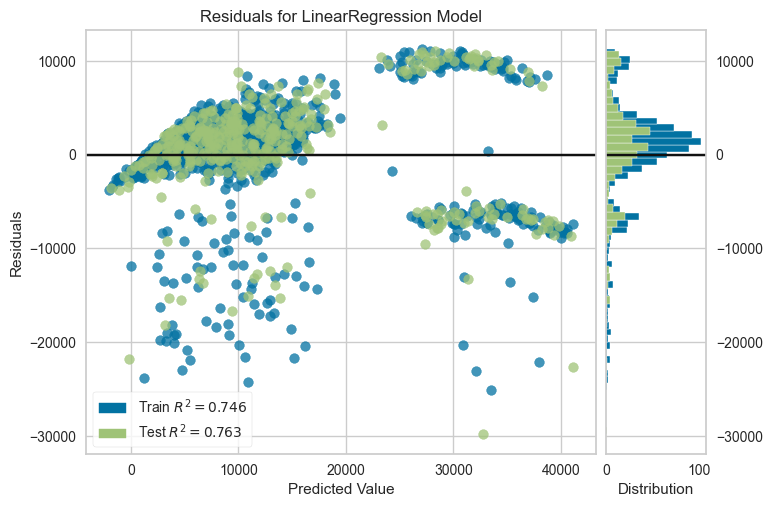

In [24]:
# 绘制训练模型的残差
plot_model(lr, plot='residuals')

In [26]:
# 使用 save_model 函数保存整个建模流水线。
save_model(lr, model_name='./insurance_data/deployment')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker'],
                                     transfor...
 dtype: int64},
                                                                         {'col': 'smoker',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': no     0
 yes    1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=

这样我们就快速完成了第 1 步。

实际业务场景下，大家会做更精细化的数据清洗、特征工程和模型调优，我们本次的目标是给大家演示从建模到部署的全流程方法，因此这个部分相对简略。

PyCaret 自动化建模的输出是一个流水线 /pipeline，包含几个数据转换步骤（如特征工程、缩放、缺失值插补等）和机器学习模型。流水线保存为 pkl 格式的文件，我们在后续构建 Flask 应用程序会使用到它。

# Experiment 2

In [28]:
s2 = setup(insurance_data, 
           target = 'charges', 
           session_id = 123,
           normalize = True,
           polynomial_features = True, 
           trigonometry_features = True, 
           feature_interaction=True,
           bin_numeric_features= ['age', 'bmi'])

TypeError: setup() got an unexpected keyword argument 'trigonometry_features'

In [30]:
s2 = setup(insurance_data,
           target = 'charges',
           session_id = 123,
           normalize = True,
           polynomial_features = True,
           bin_numeric_features= ['age', 'bmi'])

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 55)"
5,Transformed train set shape,"(936, 55)"
6,Transformed test set shape,"(402, 55)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


In [34]:
s2

In [10]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2476.5333,1.792665e+07,4233.9880,0.8929,0.3878,0.2842
1,3355.1345,3.404316e+07,5834.6515,0.8021,0.4613,0.3304
2,2919.7578,2.261994e+07,4756.0423,0.7136,0.5533,0.3790
3,2964.9649,2.283861e+07,4778.9761,0.8093,0.5456,0.4029
4,3097.0904,2.838265e+07,5327.5369,0.7889,0.5248,0.2831
5,2979.1330,2.035337e+07,4511.4710,0.8691,0.3543,0.2744
6,2687.7389,2.234181e+07,4726.7128,0.8480,0.4020,0.3279
7,3123.5060,2.697542e+07,5193.7863,0.8517,0.4707,0.3089
8,2813.0890,2.055905e+07,4534.2087,0.8672,0.3759,0.3151
9,3110.4590,2.651683e+07,5149.4496,0.8292,0.4661,0.3353


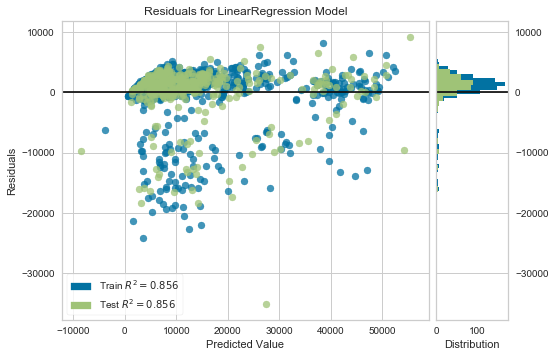

In [11]:
plot_model(lr)

In [35]:
save_model(lr, './insurance_data/deployment_241001')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker'],
                                     transfor...
                                                               use_cat_names=True))),
                 ('polynomial_features',
                  TransformerWrapper(transformer=PolynomialFeatures(include_bias=False))),
                 ('bin_numeric_features',
                  TransformerWrapper(include=['age', 'bmi'],
                                     transformer=KBinsDiscretizer(encode='ordinal',
                 

In [39]:
deployment_241001 = load_model('./insurance_data/deployment_241001')

Transformation Pipeline and Model Successfully Loaded


In [40]:
deployment_241001

Pipeline(memory=FastMemory(location=C:\Users\work\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['age', 'bmi', 'children'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['sex', 'smoker', 'region'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWr...
                                                              use_cat_names=True))),
                ('polynomial_features',
                 TransformerWrapper(transformer=PolynomialFeatures(include_bias=False))),
                ('bin_numeric_features',
                 TransformerWrapper(include=['age', 'bmi'],
                                    transformer=KBinsDiscretizer(encode='ordinal',
                                                                 strategy='kmeans'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model', LinearRegression(n_jobs=-1))])

In [24]:
import requests
url = 'http://127.0.0.1:5000/predict_api'
pred = requests.post(url,json={'age':55, 'sex':'male', 'bmi':59, 'children':1, 'smoker':'no', 'region':'northwest'})
print(pred.json())

22571.73758669605
